<a href="https://colab.research.google.com/github/samp3209/ChamplainDataScienceClub/blob/main/HousingRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data imports

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# *Clean*

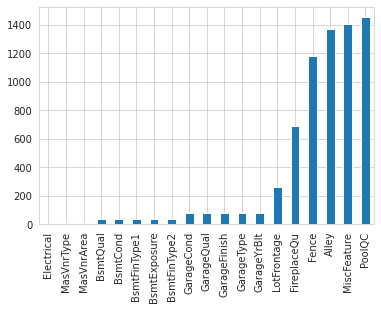

In [6]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [8]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

# Data exploration

The target variable for this dataset is SalePrice
The features we are looking at are:
Find correlation between 

In [3]:
print(train.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [4]:
train.corr()

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415   -0.238518     0.392075  0.260833     0.537808   
1stFlrSF       0.010496   -0.251758     0.457181  0.299475     0.476224   
2ndFlrSF       0.005590    0.307886     0.080177  0.050986     0.295493   
LowQualFinSF  -0.044230    0.046474     0.038469  0.004779    -0.030429   
GrLivArea      0.008273    0.074853     0.402797  0.263116     0.593007   
BsmtFullBath   0.002289    0.003491     0.100949  0.158155     0.111098   
BsmtHalfBath  -0.020155   -0.002333    -0.007234  0.048046    -0.040150   
FullBath       0.005587    0.131608     0.198769  0.126031     0.550600   
HalfBath       0.006784    0.177354     0.053532  0.014259     0.273458   
BedroomAbvGr   0.037719   -0.023438     0.263170  0.119690     0.101676   
KitchenAbvGr   0.002951    0.281721    -0.006069 -0.017784    -0.183882   
TotRmsAbvGrd   0.027239    0.040380     0.352096  0.190015     0.427452   
Fireplaces    -0.019772   -0.045569     0.266639  0.271364     0.396765   
GarageYrBlt    0.000072    0.085072     0.070250 -0.024947     0.547766   
GarageCars     0.016570   -0.040110     0.285691  0.154871     0.600671   
GarageArea     0.017634   -0.098672     0.344997  0.180403     0.562022   
WoodDeckSF    -0.029643   -0.012579     0.088521  0.171698     0.238923   
OpenPorchSF   -0.000477   -0.006100     0.151972  0.084774     0.308819   
EnclosedPorch  0.002889   -0.012037     0.010700 -0.018340    -0.113937   
3SsnPorch     -0.046635   -0.043825     0.070029  0.020423     0.030371   
ScreenPorch    0.001330   -0.026030     0.041383  0.043160     0.064886   
PoolArea       0.057044    0.008283     0.206167  0.077672     0.065166   
MiscVal       -0.006242   -0.007683     0.003368  0.038068    -0.031406   
MoSold         0.021172   -0.013585     0.011200  0.001205     0.070815   
YrSold         0.000712   -0.021407     0.007450 -0.014261    -0.027347   
SalePrice     -0.021917   -0.084284     0.351799  0.263843     0.790982   

               OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass       -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage      -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea          -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual      -0.091932   0.572323      0.550684    0.411876    0.239666   
OverallCond       1.000000  -0.375983      0.073741   -0.128101   -0.046231   
YearBuilt        -0.375983   1.000000      0.592855    0.315707    0.249503   
YearRemodAdd      0.073741   0.592855      1.000000    0.179618    0.128451   
MasVnrArea       -0.128101   0.315707      0.179618    1.000000    0.264736   
BsmtFinSF1       -0.046231   0.249503      0.128451    0.264736    1.000000   
BsmtFinSF2        0.040229  -0.049107     -0.067759   -0.072319   -0.050117   
BsmtUnfSF        -0.136841   0.149040      0.181133    0.114442   -0.495251   
TotalBsmtSF      -0.171098   0.391452      0.291066    0.363936    0

In [5]:
i=0
for i in range(0,81):
  col = train.columns[i]
  try:
    print(col)
    print(train[col].corr(train['SalePrice']))
  except TypeError:
    print('non numeric column')


Id
-0.021916719443431116
MSSubClass
-0.08428413512659531
MSZoning
non numeric column
LotFrontage
0.35179909657067804
LotArea
0.2638433538714056
Street
non numeric column
Alley
non numeric column
LotShape
non numeric column
LandContour
non numeric column
Utilities
non numeric column
LotConfig
non numeric column
LandSlope
non numeric column
Neighborhood
non numeric column
Condition1
non numeric column
Condition2
non numeric column
BldgType
non numeric column
HouseStyle
non numeric column
OverallQual
0.7909816005838044
OverallCond
-0.07785589404867803
YearBuilt
0.5228973328794969
YearRemodAdd
0.5071009671113865
RoofStyle
non numeric column
RoofMatl
non numeric column
Exterior1st
non numeric column
Exterior2nd
non numeric column
MasVnrType
non numeric column
MasVnrArea
0.4774930470957163
ExterQual
non numeric column
ExterCond
non numeric column
Foundation
non numeric column
BsmtQual
non numeric column
BsmtCond
non numeric column
BsmtExposure
non numeric column
BsmtFinType1
non numeric colu

In [9]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [10]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(train, features)

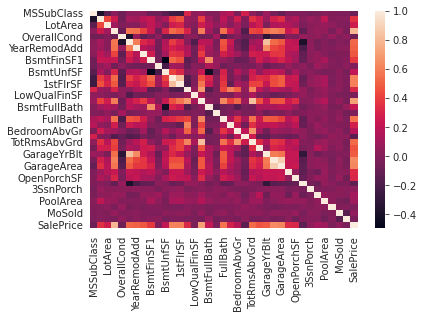

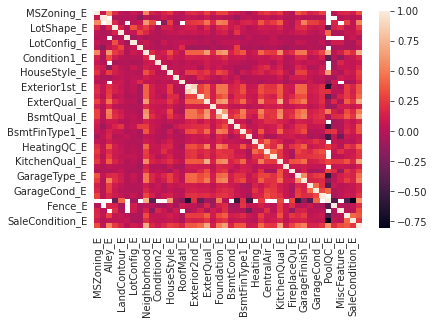

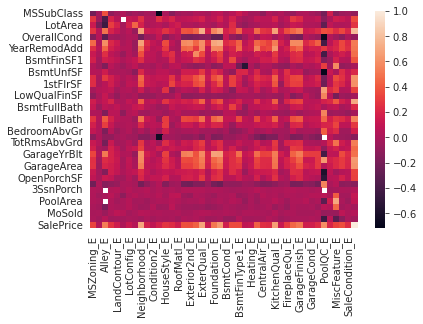

In [11]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0.7545029157149727


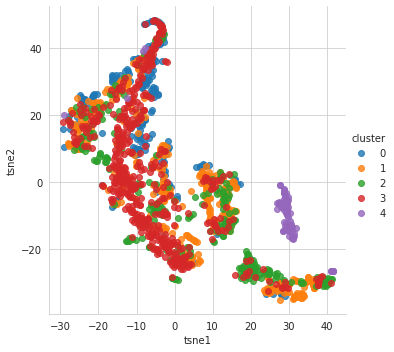

In [14]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))